In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import schedulefree

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys

sys.path.append("../auto_LiRPA/")
import auto_LiRPA
from auto_LiRPA.operators.gurobi_maxpool_lp import compute_maxpool_bias

import time

/home/philipp/VerifyNN/alpha-beta-Crown-fork/jupyter/../auto_LiRPA/auto_LiRPA/operators/gurobi_maxpool_lp.py:189: DeprecationWarning: invalid escape sequence '\i'
  """


In [4]:
# now for a lot of neurons
n_neurons = 100
l = torch.randn(n_neurons, 1, 2, 2)
u = torch.abs(torch.randn(n_neurons, 1, 2, 2)) + l
alpha = torch.rand(n_neurons, 1, 2, 2)

biases = compute_maxpool_bias(l, u, alpha)

100%|██████████| 100/100 [00:00<00:00, 160.52it/s]


In [2]:
def normalize_bounds(l, u):
    """
    Takes bounds tensors and normalizes them to [0, 1], s.t. smallest lower bound is mapped to 0
    and largest upper bound is mapped to 1

    args:
        l (batch x channels x w x h) - concrete lower bounds
        u (batch x channels x w x h) - concrete upper bounds

    returns:
        l_norm (batch x channels x w x h) - normalized concrete lower bounds
        u_norm (batch x channels x w x h) - normalized concrete upper bounds
    """
    lmin = l.flatten(-2).min(dim=-1)[0]
    umax = u.flatten(-2).max(dim=-1)[0]
    lmin = lmin.unsqueeze(1)
    umax = umax.unsqueeze(1)

    l_norm = (l.flatten(-2) - lmin) / (umax - lmin)
    u_norm = (u.flatten(-2) - lmin) / (umax - lmin)
    l_norm = l_norm.view(l.shape)
    u_norm = u_norm.view(u.shape)

    return l_norm, u_norm

In [3]:
def sort_by_lower_bound(X):
    """
    Sorts tensor of shape (n_neurons, 3, w, h) by concrete lower bounds (the first channel dim).
    """
    _, ind_tensor = X.flatten(-2)[:,0].sort(dim=-1)
    ind_tensor = ind_tensor.unsqueeze(1).expand(-1, X.size(1), -1)

    return torch.gather(X.flatten(-2), dim=2, index=ind_tensor).view(X.shape)

In [4]:
def create_dataset(n_neurons, h, w):
    # since the normalized version suffices, just stick to that
    x1 = torch.rand(n_neurons, 1, h, w)
    x2 = torch.rand(n_neurons, 1, h, w)

    l = torch.where(x1 <= x2, x1, x2)
    u = torch.where(x1  > x2, x1, x2)
    l, u = normalize_bounds(l, u)

    alpha = torch.rand(n_neurons, 1, h, w)

    biases = compute_maxpool_bias(l, u, alpha)

    return l, u, alpha, biases

In [19]:
l, u, alpha, biases = create_dataset(100, 2, 2)

100%|██████████| 100/100 [00:00<00:00, 145.46it/s]


In [20]:
X = torch.cat((l, u, alpha), dim=1)

The dataset has shape `(n_neurons, 3, h, w)` and
- `X[:,0,:,:]` represents the lower bounds
- `X[:,1,:,:]` represents the upper bounds
- `X[:,2,:,:]` represents the slopes

In [21]:
X.shape

torch.Size([100, 3, 2, 2])

In [22]:
X_sorted = sort_by_lower_bound(X)
X_sorted[:2, 0, :, :]

tensor([[[0.0000, 0.0693],
         [0.2860, 0.8869]],

        [[0.0000, 0.0558],
         [0.3411, 0.4535]]])

In [23]:
X_sorted[:2, 1, :, :]

tensor([[[0.2026, 1.0000],
         [0.8710, 0.9930]],

        [[0.0168, 0.5627],
         [0.6591, 1.0000]]])

In [5]:
def create_tensor_dataset(n_neurons_train, n_neurons_val, h, w, sort_by_lb=True):
    l, u, alpha, bias = create_dataset(n_neurons_train, h, w)
    X = torch.cat((l, u, alpha), dim=1)

    if sort_by_lb:
        X = sort_by_lower_bound(X)

    dataset_train = TensorDataset(X, bias)

    l, u, alpha, bias = create_dataset(n_neurons_val, h, w)
    X = torch.cat((l, u, alpha), dim=1)

    if sort_by_lb:
        X = sort_by_lower_bound(X)
        
    dataset_val = TensorDataset(X, bias)

    return dataset_train, dataset_val

In [ ]:
CREATE_DATASET = False

if CREATE_DATASET:
    ds_train, ds_val = create_tensor_dataset(100, 10, 2, 2)
    torch.save(ds_train, './datasets/maxpool2x2_train_clean.pth')
    torch.save(ds_val, './datasets/maxpool2x2_val_clean.pth')
else:
    ds_train = torch.load('./datasets/maxpool2x2_train_clean.pth')
    ds_val   = torch.load('./datasets/maxpool2x2_val_clean.pth')

In [30]:
batch_size = 32
train_dataloader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(ds_val, batch_size=batch_size)

In [35]:
def train_loop(net, train_dataloader, val_dataloader, patience=10, num_epochs=100, timeout=60, lossfun='mse', opt='adam'):
    if lossfun == 'mse':
        criterion = nn.MSELoss()
    elif lossfun == 'mae':
        criterion = nn.L1Loss()
    else:
        raise ValueError('Unknown loss function!')
    
    if opt == 'adam':
        optimizer = optim.Adam(net.parameters())
    elif opt == 'schedulefree':
        optimizer = schedulefree.AdamWScheduleFree(net.parameters(), lr=0.0025)
    else:
        raise ValueError('Uknown optimizer!')


    train_losses = []
    train_maes = []
    val_losses = []
    val_maes = []
    best_val_loss = float('inf')
    early_stopping_cnt = 0
    t_start = time.time()
    for epoch in range(num_epochs):
        t_cur = time.time()
        if t_cur - t_start > timeout:
            print(f"Timeout reached ({t_cur - t_start} sec)")
            break 
        
        net.train()

        if opt == 'schedulefree':
            optimizer.train()

        train_loss = 0.
        train_mae = 0.
        for batch_X, batch_y in train_dataloader:
            y_hat = net(batch_X)
            loss = criterion(y_hat, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_mae += torch.abs(y_hat - batch_y).mean().item()

        train_loss /= len(train_dataloader)
        train_mae /= len(train_dataloader)
        train_losses.append(train_loss)
        train_maes.append(train_mae)


        net.eval()

        if opt == 'schedulefree':
            optimizer.eval()
            
        val_loss = 0
        val_mae = 0
        with torch.no_grad():
            for batch_X, batch_y in val_dataloader:
                y_hat = net(batch_X)
                loss = criterion(y_hat, batch_y)
                val_loss += loss.item()
                val_mae += torch.abs(y_hat - batch_y).mean().item()

        val_loss /= len(val_dataloader)
        val_mae /= len(val_dataloader)
        val_losses.append(val_loss)
        val_maes.append(val_mae)

        print(f"Epoch [{epoch + 1}/{num_epochs}] - train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, train_mae: {train_mae:.4f}, val_mae: {val_mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_cnt = 0
            best_net_state = net.state_dict()
        else:
            early_stopping_cnt += 1
            if early_stopping_cnt >= patience:
                print(f"Stopping early (patience of {patience} reached)")
                break


    print("Training completed")
    return train_losses, val_losses, train_maes, val_maes, best_net_state

In [33]:
n_neurons = 50
h = 2
w = 2
net = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*h*w, n_neurons),     torch.nn.ReLU(), 
                                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(), 
                                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(), 
                                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(),
                                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(),
                                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(),
                                              torch.nn.Linear(n_neurons, 1))

In [36]:
train_losses, val_losses, train_maes, val_maes, best_state = train_loop(net, train_dataloader, val_dataloader, timeout=10, patience=5000, num_epochs=1000)

Epoch [1/1000] - train_loss: 0.0180, val_loss: 0.0214, train_mae: 0.1086, val_mae: 0.1224
Epoch [2/1000] - train_loss: 0.0137, val_loss: 0.0159, train_mae: 0.0965, val_mae: 0.0979
Epoch [3/1000] - train_loss: 0.0095, val_loss: 0.0206, train_mae: 0.0831, val_mae: 0.1136
Epoch [4/1000] - train_loss: 0.0053, val_loss: 0.0129, train_mae: 0.0591, val_mae: 0.0988
Epoch [5/1000] - train_loss: 0.0083, val_loss: 0.0110, train_mae: 0.0757, val_mae: 0.0874
Epoch [6/1000] - train_loss: 0.0068, val_loss: 0.0128, train_mae: 0.0678, val_mae: 0.0863
Epoch [7/1000] - train_loss: 0.0033, val_loss: 0.0098, train_mae: 0.0453, val_mae: 0.0856
Epoch [8/1000] - train_loss: 0.0045, val_loss: 0.0088, train_mae: 0.0541, val_mae: 0.0783
Epoch [9/1000] - train_loss: 0.0035, val_loss: 0.0100, train_mae: 0.0486, val_mae: 0.0782
Epoch [10/1000] - train_loss: 0.0029, val_loss: 0.0094, train_mae: 0.0419, val_mae: 0.0819
Epoch [11/1000] - train_loss: 0.0030, val_loss: 0.0105, train_mae: 0.0429, val_mae: 0.0842
Epoch [1

In [ ]:
#torch.save(train_losses, './train_losses.pth')

# Load Data from Overfit Experiment

I trained a `6x50` model for 48h on the server.

In [6]:
n_neurons = 50
h = 2
w = 2
net = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(3*h*w, n_neurons),     torch.nn.ReLU(), 
                                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(), 
                                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(), 
                                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(),
                                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(),
                                              torch.nn.Linear(n_neurons, n_neurons), torch.nn.ReLU(),
                                              torch.nn.Linear(n_neurons, 1))

state = torch.load('./net_overfit_best_state.pth')
net.load_state_dict(state)

<All keys matched successfully>

In [7]:
train_losses = torch.load('./train_losses.pth')
val_losses   = torch.load('./val_losses.pth')

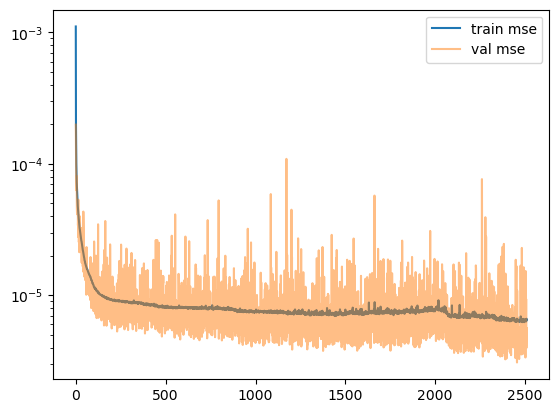

In [8]:
plt.plot(train_losses, label="train mse")
plt.plot(val_losses, label="val mse", alpha=0.5)
plt.yscale('log')
plt.legend()

Is there a noticeable improvement from epoch $2000$ onward?

# Export to ONNX

In [52]:
dummy_input = torch.randn(1, 3, 2, 2)

models = [net]
onnx_files = ['net6x50_overfit.onnx']

for model, filename in zip(models, onnx_files):
    torch.onnx.export(model, dummy_input, './verification/models/' + filename, export_params=True, do_constant_folding=True, opset_version=7, input_names=['X'], output_names=['Y'])

# Analysis on Training/Validation Dataset

In [9]:
ds_train = torch.load('./datasets/maxpool2x2_train_clean.pth')
ds_val   = torch.load('./datasets/maxpool2x2_val_clean.pth')

In [22]:
X, y = ds_train.tensors

y_pred = net(X)

diffs = (y_pred - y).detach().numpy()
print(np.min(diffs))
print(np.max(diffs))

-0.042597175
0.07933128


-1.5427221
0.99841356


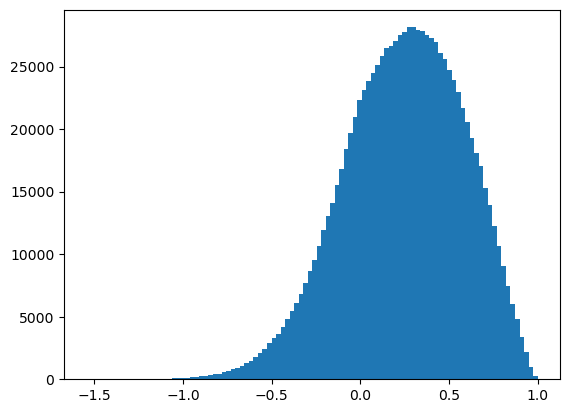

In [25]:
print(np.min(y.detach().numpy()))
print(np.max(y.detach().numpy()))
plt.hist(y.detach().numpy(), bins=100)
plt.show()

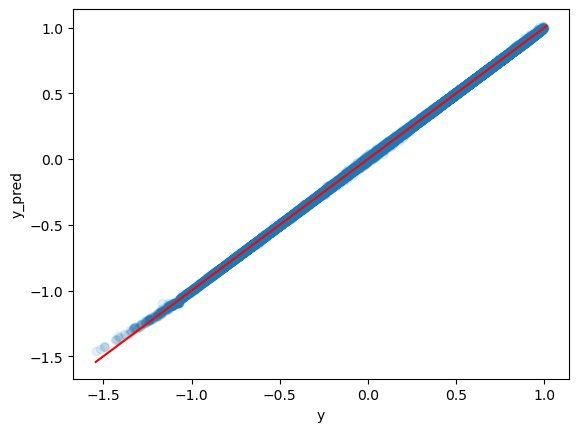

In [29]:
minval = np.minimum(np.min(y.detach().numpy()), np.min(y_pred.detach().numpy()))
maxval = np.maximum(np.max(y.detach().numpy()), np.max(y_pred.detach().numpy()))

plt.plot([minval, maxval], [minval, maxval], color='r')
plt.scatter(y.detach().numpy(), y_pred.detach().numpy(), alpha=0.1)
plt.xlabel("y")
plt.ylabel("y_pred")
plt.show()

In [11]:
X, y = ds_val.tensors

y_pred = net(X)

diffs_val = (y_pred - y).detach().numpy()
print(np.min(diffs_val))
print(np.max(diffs_val))

-0.034857716
0.04430306


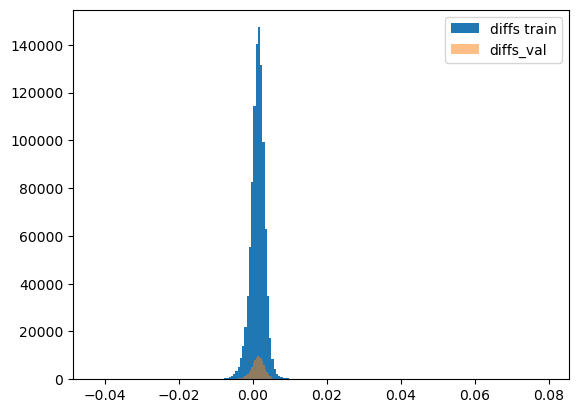

In [12]:
plt.hist(diffs, bins=200, label="diffs train")
plt.hist(diffs_val, bins=200, label="diffs_val", alpha=0.5)
plt.legend()
plt.show()

In [13]:
l  = torch.tensor([0.0, 0.7933202606721373, 0.7933202636248111, 0.808086354409053]).reshape(1,1, 2, 2)
u  = torch.tensor([1.0, 1.0, 0.7933202636248111, 0.8783314736631597]).reshape(1,1, 2, 2)
alpha  = torch.tensor([1.0, 0.7543959014578894, 0.059299014306145405, 0.041313514679354915]).reshape(1,1, 2, 2)
xs = torch.tensor([0.01557256582605028, 0.7933202606721358, 0.7933202626353946, 0.8783314736631597]).reshape(1,1, 2, 2)

x = torch.cat((l, u, alpha), dim=1)

In [14]:
net(x)

tensor([[0.1971]], grad_fn=<AddmmBackward0>)

In [15]:
biases = compute_maxpool_bias(l, u, alpha)

100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

0: ObjVal =  0.6789055316618993
1: ObjVal =  -0.16517610327182686
skipping x_2 because u_2 = 0.7933202385902405 < 0.8080863356590271 = max(l)
3: ObjVal =  -0.19652386379865883


In [77]:
biases

tensor([[0.1965]])

In [19]:
print(xs.flatten() - (torch.dot(alpha.flatten(), xs.flatten()) + biases.flatten()))
#print(xs.flatten()[1] - torch.dot(alpha.flatten(), xs.flatten()))
#print(xs.flatten()[2] - torch.dot(alpha.flatten(), xs.flatten()))
#print(xs.flatten()[3] - torch.dot(alpha.flatten(), xs.flatten()))

tensor([-0.8783, -0.1006, -0.1006, -0.0156])


In [20]:
torch.dot(alpha.flatten(), xs.flatten()) + biases.flatten()

tensor([0.8939])

In [21]:
torch.dot(alpha.flatten(), xs.flatten())

tensor(0.6974)